## GNNs - Node classification with Graph Convolutional Networks in pytorch

Here we present two example cases of using GCNs - one with undirected graphs, and one with (a spiked flavor for) directed.

Model architectures/parameterizations are inspired by the following articles:
- T. Kipf and M. Welling, “Semi-Supervised Classification with Graph Convolutional Networks”, 2016, arXiv: 1609.02907
- M. Schlichtkrull, "Modeling Relational Data with Graph Convolutional Networks", 2017, arXiv: 1703.06103
- P. Mernyei and C. Cangea, "Wiki-CS: A Wikipedia-Based Benchmark for Graph Neural Networks", 2022, arXiv: 2007.02901

### Undirected graphs: The Zachary's karate club network example

Starting with the undirected graph GCN flavor, this commonly used dataset contains one undirected graph with 34 features and 78 edges (156 non-unique edges since PyG uses coordinate format for the sparse connectivity matrix A). There are 4 truth nodes, one for each class, and the task at hand is to infer the class for the rest of the nodes.

Let's start by loading the data from PyG:

In [1]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item())
print("Is directed:", data.is_directed())

Dataset: KarateClub()
# Graphs: 1
# Features: 34
# Classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Training nodes: 4
Is directed: False


We can use Networkx to visualize the karate club data, the color-encoding represents the class of each node.

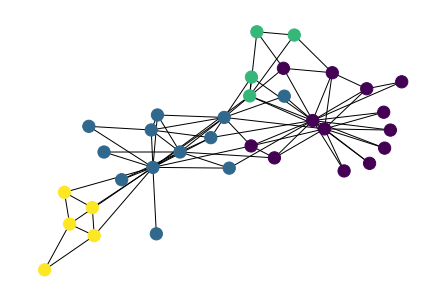

In [2]:
import networkx as nx
from torch_geometric.utils import to_networkx

# transform to networkx format
G = to_networkx(data, to_undirected=True)

nx.draw(G, node_color = data.y, node_size=150)

#### Node classification with a GCN (undirected graph)

- A 3-layer GCN will result in three successive propagation steps, and every node being updated with information from neighbouring nodes 3-hops away.
- The number of input units in the first layer is the same as the number of features for every node.
- We choose a hidden layer dimensionality of 8, except for the last layer where we have a two-dimensional output so that we can visualize the learned latent embedding as a 2D scatterplot.
- We use the hyperbolic tangent as a non-linear activation function.
- The output layer maps the 2D node embedding to 1 out of the four classes.
- We use a cross-entropy loss to obtain a probability distribution over the possible classes.

In [3]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
        
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(123)
        
        self.conv1 = GCNConv(dataset.num_features, 8)
        self.conv2 = GCNConv(8, 8)
        self.conv3 = GCNConv(8, 2)
        self.classifier = Linear(2, dataset.num_classes)  
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        out = self.classifier(h)
        
        return out, h
    
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [4]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss, h

In [5]:
epochs = range(1, 201)
losses = []
embeddings = []

for epoch in epochs:
    loss, h = train(data)
    losses.append(loss)
    embeddings.append(h)
    #print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

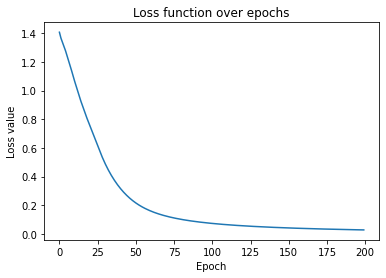

In [6]:
import matplotlib.pyplot as plt

losses_np = []

for l in losses:
    losses_np.append(l.item())
    
plt.plot(losses_np)
plt.title("Loss function over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

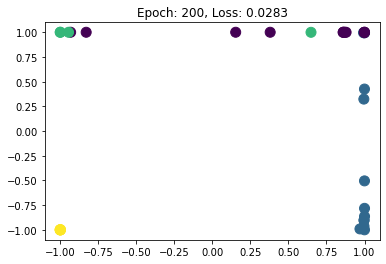

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Animation function (called sequentially)
def animate(i):
    ax.clear()
    h = embeddings[i]
    h = h.detach().numpy() # transform pytorch tensor to numpy array
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
    ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

fig = plt.figure()
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(epochs)) # animator call

gif_writer = animation.PillowWriter(fps=20)
anim.save('em0.gif', writer=gif_writer)

![SegmentLocal](em0.gif "gif")

### Directed graphs: GCN for WikiCS

Let's start by loading the dataset (using `is_undirected = False`):

In [8]:
from torch_geometric.datasets import WikiCS

dataset = WikiCS(root='./WikiCS_data/', is_undirected = False)

print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

data = dataset[0]
print(data)
#print("Training nodes:", data.train_mask.sum().item())
print("Is directed:", data.is_directed())

Dataset: WikiCS()
# Graphs: 1
# Features: 300
# Classes: 10
Data(x=[11701, 300], edge_index=[2, 297110], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])
Is directed: True


This directed graph consists of 11,701 nodes, with 300 node features each. 

For this case, we will follow a more analytical implementation of the GCNConv layer. The reason is that the authors of the GCNConv article, suggest that for directed graphs GCNs can be used with a different normalization; instead of using the graph convolutional operator $ \mathbf{X}' = \mathbf{\hat{D}}^{-1/2} \ \mathbf{\hat{A}} \ \mathbf{\hat{D}}^{-1/2} \ \mathbf{X} \ \mathbf{\Theta} $ they simply use $ \mathbf{X}' = \mathbf{\hat{D}}^{-1} \ \mathbf{\hat{A}}\ \mathbf{X} \ \mathbf{\Theta} $ for the directed case. Where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I} $ is the adjacency matrix after adding the self-loops and $ \mathbf{\hat{D}}_{ii} = \sum_{j=0} \mathbf{\hat{A}}_{ij} $ is its diagonal degree matrix.


The GCN layer is defined as: 

$$ \mathbf{x}_{i}^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{i\}} \ \dfrac{1}{\sqrt{deg(i)} \ \sqrt{deg(j)}} \ ( \mathbf{\Theta^{T}} \ \mathbf{x}_{j}^{(k-1)} ) $$

where the neighboring node features are first transformed by a weight vector $\mathbf{\Theta}$, normalized by their degree, and finally summed up. This formula can be broken down into the following steps:

- Add self-loops to the adjacency matrix.

- Linearly transform node feature matrix.

- Compute normalization coefficients.

- Normalize node features in message().

- Sum up the neighboring node features (using an "add" aggregation).

(following PyG documentation)

In [9]:
from torch.nn import Dropout
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNCo(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5)
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        x = self.lin(x)

        # Step 3: Compute normalization
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        
        #for undirected graphs:
        #deg_inv_sqrt = deg.pow(-0.5)
        
        
        #for directed graphs:
        deg_inv_sqrt = deg.pow(-1)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features
        # view behaves like numpy.reshape()
        return torch.Tensor(norm).view(-1, 1) * x_j

[Following parametrization of Mernyei and Cangea, 2022] (WIP)

In [10]:
class dir_GCN(torch.nn.Module):
        
    def __init__(self):
        super(dir_GCN, self).__init__()
        torch.manual_seed(123)
        
        self.conv1 = GCNCo(dataset.num_features,33)
        self.dropout = Dropout(p=0.25)
        self.conv2 = GCNCo(300, 2)
        self.dropout = Dropout(p=0.25)
        self.classifier = Linear(2, dataset.num_classes)  
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(x, edge_index)
        h = h.tanh()
        out = self.classifier(h)
        
        return out, h
    
model = dir_GCN()
print(model)

dir_GCN(
  (conv1): GCNCo()
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): GCNCo()
  (classifier): Linear(in_features=2, out_features=10, bias=True)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)

def train_dir(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    
    return loss, h

In [12]:
epochs = range(1, 250)
losses = []
embeddings = []

for epoch in epochs:
    loss, h = train_dir(data)
    losses.append(loss)
    embeddings.append(h)
    #print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

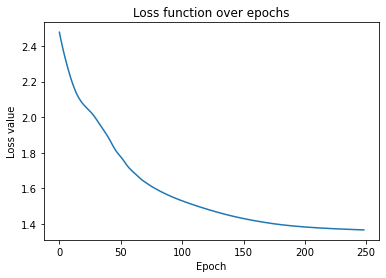

In [13]:
losses_np = []

for l in losses:
    losses_np.append(l.item())
    
plt.plot(losses_np)
plt.title("Loss function over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

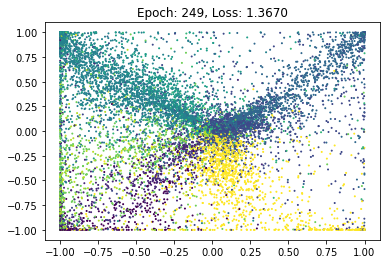

In [14]:
# animation function (called sequentially)
def animate(i):
    ax.clear()
    h = embeddings[i]
    h = h.detach().numpy()
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=1)
    ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

fig = plt.figure()
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(epochs))

gif_writer = animation.PillowWriter(fps=20)
anim.save('emdir0.gif', writer=gif_writer)

![SegmentLocal](emdir0.gif "gif1")